This is a rundown of the model we used to detect humor. We used BERT as our encoder, and then passed its output into a neural network to classify each sequence as a joke or a non-joke. Here is an overview of what we did, and how well our model performed, along with possible next steps to improve the model.

In [1]:
!pip install --upgrade transformers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import transformers as ppb # BERT Model
import pickle # decode pickled data
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = ppb.AutoTokenizer.from_pretrained("bert-base-uncased")
model = ppb.TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

def lemmatize(s):
    wordnet_lemmatizer = WordNetLemmatizer()
    return " ".join([wordnet_lemmatizer.lemmatize(w,'v') for w in s.split(" ")])
def lower(s):
    return s.lower()
def clean(data):
    for item in data:
        lemmatize(item)
        lower(item)
        re.sub(r'\d+', '', item) # remove nums
    return data
def tokenize(text):
    tokenized = tokenizer(text, padding=True, truncation=True, return_tensors="tf")
    return tokenized
def process(data):
    cleaned = clean(data)
    return tokenize(data)

train_x = pd.read_pickle("../input/humor-detection/X_train.pickle")
train_y = pd.read_pickle("../input/humor-detection/y_train.pickle")
test_x = pd.read_pickle("../input/humor-detection/X_test.pickle")
test_y = pd.read_pickle("../input/humor-detection/y_test.pickle")
model.load_weights("../input/week-3-bert-implementation-run/model/model_checkpoint.ckpt")

train_batch = process(train_x)
test_batch = process(test_x)

def predict(joke, model):
    test_jokes = [
    "Don’t you hate people who use big words just to make themselves look perspicacious?",
    "My friend thinks he is smart. He told me an onion is the only food that makes you cry, so I threw a coconut at his face.",
    "So far, consumers haven’t returned to the sort of panic buying frenzy that sent packaged-food manufacturers scrambling earlier this year.",
    "Wall Street Week Ahead: Stock investors cast wary eye on yield rally",
    "What happens to a frog's car when it breaks down? It gets toad away."
    ]
    test_jokes.append(joke)
    tk = tokenizer(test_jokes, padding=True)
    out = model.predict(x=tk.input_ids)
    boolean_pred = np.argmax(out[0], axis=1)
    return boolean_pred[len(boolean_pred)-1] == 1

     |████████████████████████████████| 1.4 MB 1.3 MB/s 
     |████████████████████████████████| 2.9 MB 7.5 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.9.2
    Uninstalling tokenizers-0.9.2:
      Successfully uninstalled tokenizers-0.9.2
  Attempting uninstall: transformers
    Found existing installation: transformers 3.4.0
    Uninstalling transformers-3.4.0:
      Successfully uninstalled transformers-3.4.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

allennlp 1.2.1 requires transformers<3.5,>=3.1, but you'll have transformers 4.0.1 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# The Model
For this classification, we are using the inbuilt <code>TFBertForSequenceClassification</code> model from huggingface's transformers package. This model already had all the functionality we were looking for, which made training and setting up the model easier. Below, is the model summary.

In [2]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6, epsilon=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric1 = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric1])
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


Most of the training of this model came towards fine-tuning the weights of BERT to better fit our task. In total, we trained 109,483,778 parameters.

The model inside is really 3 different layers of modelling.
1. <code>TFBertMainLayer</code> - This is the part which takes in the tokenized sequence inputs and converts them into tensors via BERT's encoding methods.
2. <code>dropout_37</code> - This layer of the neural network selectively "drops out", or removes a couple of neurons from the input into the next layer, as a method of regularization.
3. <code>classifier</code> - This layer takes in the regularized BERT outputs and classifies each as a Joke or Non-Joke (positive or negative)

The training for this model, on average, takes about 1 hour with a Nvidia Tesla k80 GPU. The hyperparameters are:
* Learning Rate: 1e-5
* Epsilon (to prevent non-zero division): 1e-8
* Epochs: 2 - two epochs were all that were necessary because by that point in time, validation loss had converged (training for any more epochs actually increased validation loss. 

# The Results

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2304
           1       0.98      0.98      0.98      1051

    accuracy                           0.99      3355
   macro avg       0.98      0.98      0.98      3355
weighted avg       0.99      0.99      0.99      3355



Text(0.5, 1.0, 'Confusion Matrix of Predicted Labels for Joke and Non-Joke Sequences')

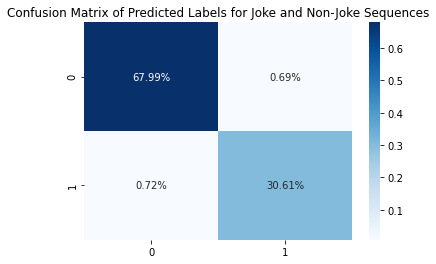

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model.predict(x=[test_batch.input_ids,test_batch.attention_mask])
y_pred_bool = np.argmax(y_pred[0], axis=1)
cf = confusion_matrix(np.array(test_y), y_pred_bool)
labels = np.array(["True Negative", "False Positive", "False Negative", "True Positive"]).reshape(2,2)
ax = sns.heatmap(cf/np.sum(cf), annot=True,fmt='.2%', cmap="Blues")
print(classification_report(test_y, y_pred_bool))
ax.set_title("Confusion Matrix of Predicted Labels for Joke and Non-Joke Sequences")

An F1-score of 99 is very high and lends evidences to say our model is doing quite well. The confusion matrix visually shows that there are minimal cases of False Positives (0.69%) and False Negatives (0.72%) being reported by the model.

There is a very high concern of overfitting here, considering the high accuracy and F1 score of the model. Howewver, since test set loss was always low, there is no overfitting with respect to this dataset. It is very likely that the test set that we were given for this prediction task was not different enough from the training set, and so it did not present a very valid metric of how well the model generalized. It is likely that while our model works very, very well on this specific dataset of jokes and non-jokes, it may not be able to generalize well to jokes which are very much unlike those in our dataset. If we were to redo this project with more data, we would probably choose a larger, more varied dataset.

Let's actually see how well the model classifies some jokes. We used jokes and non-jokes sequences from https://www.joydeepdeb.com/misc/one-liners.html, https://www.rd.com/list/short-jokes/, https://www.reuters.com/, https://www.wired.com/ to show the results below. Of note, none of these examples are in the train or test set for our model.

In [4]:
def pretty_print_prediction(seq):
    print("Input Sequence: %s" % seq)
    prediction = predict(seq, model)
    print("Prediction: %s" % ("True - Is a joke!" if prediction else "False - Is not a joke!"))
    
pretty_print_prediction("Why did the chicken cross the road? To get to the other side!")

Input Sequence: Why did the chicken cross the road? To get to the other side!
Prediction: True - Is a joke!


The model here predicted the classic "Why did the chicken cross the road?" joke to be humorous, which means that it can distinguish on a basic level what is humor, even if the joke isn't too complex.

In [5]:
pretty_print_prediction("A conclusion is the part where you got tired of thinking.")

Input Sequence: A conclusion is the part where you got tired of thinking.
Prediction: True - Is a joke!


Interestingly, our model can recognize sarcasm in a joke. This is a feature that is more subtle than a word pun or another more straightforward type of joke. It is good then that our model can properly understand even more subtle humor like this.

In [6]:
pretty_print_prediction("Did you hear about the mathematician who’s afraid of negative numbers? He’ll stop at nothing to avoid them")

Input Sequence: Did you hear about the mathematician who’s afraid of negative numbers? He’ll stop at nothing to avoid them
Prediction: True - Is a joke!


Two phrase jokes are also recognized as well, so the model is able to connect both phrases and recognize that there is a joke there.

In [7]:
pretty_print_prediction("Interpol warns that COVID-19 vaccines could be targeted by criminals")

Input Sequence: Interpol warns that COVID-19 vaccines could be targeted by criminals
Prediction: False - Is not a joke!


Here, it can pretty safely recognize that this headline is not a joke, distinguishing the sequence as such.

In [8]:
pretty_print_prediction("Global equities hover near record highs as stimulus hopes build")
pretty_print_prediction("19 Delightful Gifts for Music Lovers and Audiophiles")

Input Sequence: Global equities hover near record highs as stimulus hopes build
Prediction: False - Is not a joke!
Input Sequence: 19 Delightful Gifts for Music Lovers and Audiophiles
Prediction: False - Is not a joke!


Picking up headlines from a variety of topics (business and retail, respectively), our model is able to tell that they are clearly not humorous sequences.

In [9]:
pretty_print_prediction("What’s the best thing about Switzerland? I don’t know, but the flag is a big plus.")

Input Sequence: What’s the best thing about Switzerland? I don’t know, but the flag is a big plus.
Prediction: True - Is a joke!


The above type of joke brings up an interesting nuance where our model can possible fail. It learned to recognize that sequences that begin with "What's" have something to do with a joke. This is problematic, seeing when some non-humorous sequences can also begin the same way. For example:

In [10]:
pretty_print_prediction("What's the square root of four? It is two.")

Input Sequence: What's the square root of four? It is two.
Prediction: True - Is a joke!


We see here how the model incorrectly predicted the statement above as a joke, because the first word was "What's". This may be due to our dataset not having a wider variety of non-joke statements that begin with "What's". Similarly,

In [11]:
pretty_print_prediction("I think pizza is great. What do you think?")

Input Sequence: I think pizza is great. What do you think?
Prediction: True - Is a joke!


Such a statement as shown above is clearly not a joke (because the Michigan Data Science Team is great!), but the use of two phrases in jokes may be more common than for non-jokes.

# Some Fun Predictions:

In [12]:
pretty_print_prediction("Tyger Tyger, burning bright, In the forests of the night; What immortal hand or eye, Could frame thy fearful symmetry?")

Input Sequence: Tyger Tyger, burning bright, In the forests of the night; What immortal hand or eye, Could frame thy fearful symmetry?
Prediction: False - Is not a joke!


Out of curiosity, the prediction above is from a segment of William Blake's *The Tyger* (lines 1-4) (https://www.poetryfoundation.org/poems/43687/the-tyger). According to our model, there is no humor in this piece of poetry, but that is very much subjective so we pass no judgement here.  

In [13]:
pretty_print_prediction("Hey you. You're finally awake. You were trying to cross the border, right?")

Input Sequence: Hey you. You're finally awake. You were trying to cross the border, right?
Prediction: True - Is a joke!


Another fun one, if you ever find yourself in the magical land of Skyrim (https://www.youtube.com/embed/15ybSy7Dqwc?start=0&end=58) , you'll enjoy the weird dialogue as much as our model does.

In [14]:
pretty_print_prediction("Michigan Data Science Team")

Input Sequence: Michigan Data Science Team
Prediction: False - Is not a joke!


They always say it is not good to question the obvious, but even our model knows that the Michigan Data Science Team is no joke.

# Conclusion
Our model for humor detection is quite strong, and in of itself is quite flexible and accurate at detecting humor as recognized in the popular conscience. However, the size and low variability of the dataset overfits our model to a specific set of jokes, which while are varies, do not fully and wholly encompass all forms of humor. In the future, models like this should select a vaster set of examples from many different sources, to obtain a more generalized humor detection process. Regardless, our model still does a very good job of detecting humor in sentences.